In [9]:
import pandas as pd
import numpy as np

# Load the dataset (adjust path if needed)
df = pd.read_csv("C:/Users/ad/Desktop/Data Science Learning Materials/Machine Learning/24001518/diabetes.csv")

# View basic info
print(df.shape)
print(df.columns)
df.head()

(768, 9)
Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [10]:
# Replace clinical impossibles (0) with NaN for cleaner plots
zero_na_cols = [
    "Glucose", "BloodPressure", "SkinThickness",
    "Insulin", "BMI"
]

df[zero_na_cols] = df[zero_na_cols].replace(0, np.nan)
print(df.isna().sum())


Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64


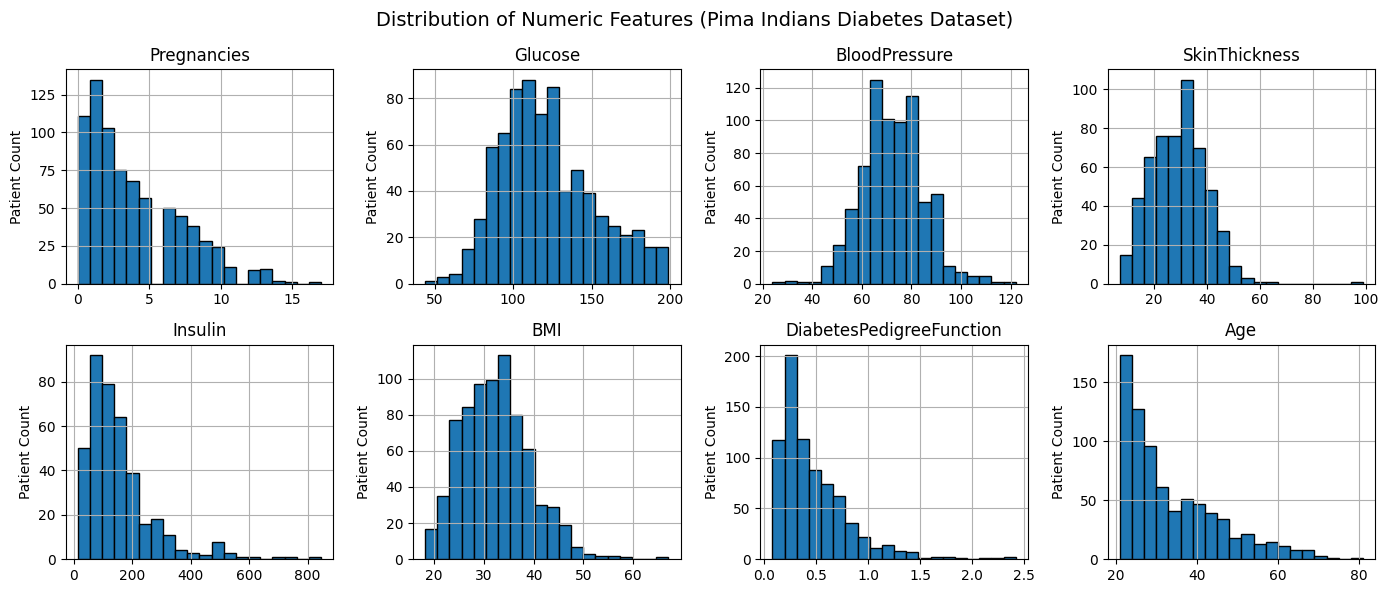

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

#Plot histograms
fig, axes = plt.subplots(2, 4, figsize=(14, 6))
axes = axes.flatten()
for i, col in enumerate(df.columns[:-1]):        # skip the Outcome column
    df[col].astype(float).hist(ax=axes[i], bins=20, edgecolor="black")
    axes[i].set_title(col)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("Patient Count")

fig.suptitle("Distribution of Numeric Features (Pima Indians Diabetes Dataset)", fontsize=14)
plt.tight_layout()
plt.show()

In [15]:
#Splitting the data
from sklearn.model_selection import train_test_split
X = df.drop("Outcome", axis=1)
y = df["Outcome"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print(f"Total samples: {len(df)}")
print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")

Total samples: 768
Training samples: 614
Testing samples: 154


In [16]:
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate

numeric_features = X.columns               # all eight are numeric
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler())
])

preprocess = ColumnTransformer(
    transformers=[("num", numeric_transformer, numeric_features)]
)

In [17]:
#Logistic regression
from sklearn.linear_model import LogisticRegression

model = Pipeline(steps=[
    ("prep",  preprocess),
    ("clf",   LogisticRegression(max_iter=1000, class_weight="balanced"))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "recall" : "recall",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

scores = cross_validate(
    model, X_train, y_train,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

print(pd.DataFrame(scores).mean())

model.fit(X_train, y_train)

from sklearn.metrics import classification_report, roc_auc_score

y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:,1]

print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))

fit_time         0.089894
score_time       0.081146
test_recall      0.700997
test_roc_auc     0.844381
test_accuracy    0.762202
dtype: float64
              precision    recall  f1-score   support

           0      0.824     0.750     0.785       100
           1      0.603     0.704     0.650        54

    accuracy                          0.734       154
   macro avg      0.714     0.727     0.717       154
weighted avg      0.747     0.734     0.738       154

Test ROC-AUC: 0.813


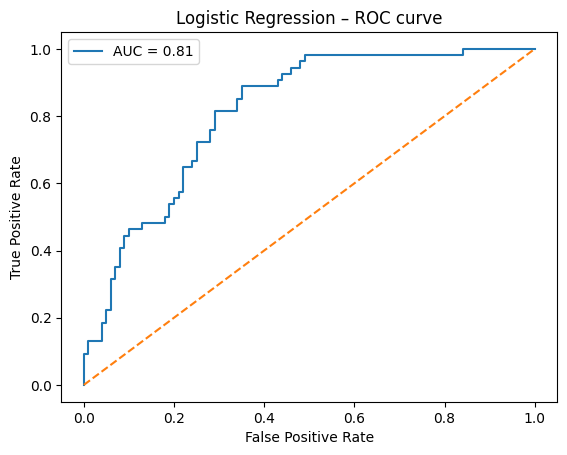

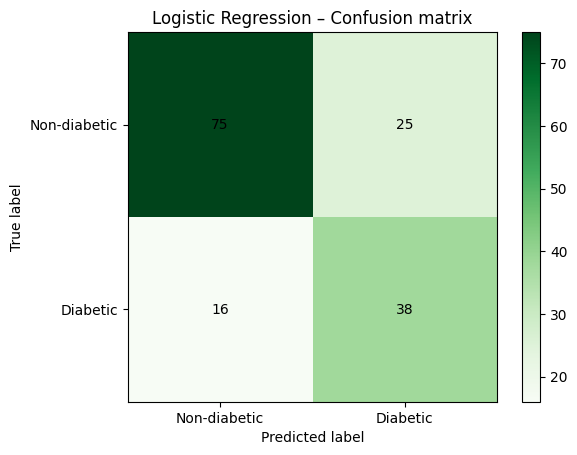

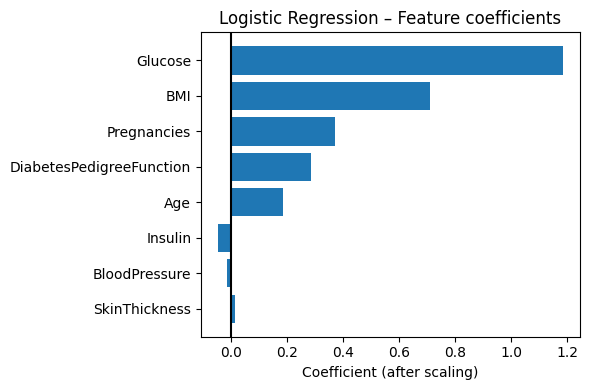

In [20]:
# Visualising Logistic Regression performance

#  Fit if not yet fitted  (comment out if baseline is already trained)
# baseline.fit(X_train, y_train)

# Predictions & proba
y_pred_lr  = model.predict(X_test)
y_proba_lr = model.predict_proba(X_test)[:, 1]

# ROC curve
from sklearn.metrics import roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

fpr, tpr, _ = roc_curve(y_test, y_proba_lr)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression – ROC curve")
plt.legend()
plt.show()

# 3  Confusion matrix
cm = confusion_matrix(y_test, y_pred_lr)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Greens")
ax.set(
    xticks=[0, 1], yticks=[0, 1],
    xticklabels=["Non-diabetic", "Diabetic"],
    yticklabels=["Non-diabetic", "Diabetic"],
    xlabel="Predicted label", ylabel="True label",
    title="Logistic Regression – Confusion matrix"
)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center")
plt.colorbar(im, ax=ax)
plt.show()

# 4  Coefficient magnitudes (interpretation)
coefs = model.named_steps["clf"].coef_[0]
order = np.argsort(np.abs(coefs))[::-1]
plt.figure(figsize=(6, 4))
plt.barh(range(len(order)), coefs[order][::-1])
plt.yticks(range(len(order)), X_test.columns[order][::-1])
plt.xlabel("Coefficient (after scaling)")
plt.title("Logistic Regression – Feature coefficients")
plt.axvline(0, color="black")
plt.tight_layout()
plt.show()


In [21]:
#Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd
import numpy as np               # only needed if you want to set np.random.seed

# 1. Pipeline: preprocessing ➜ random-forest
rf_model = Pipeline(steps=[
    ("prep",  preprocess),                      # median-impute + scale
    ("clf",   RandomForestClassifier(
                 n_estimators=300,              # number of trees
                 max_depth=6,                   # shallow trees reduce over-fit
                 class_weight="balanced",       # handle 35 % positives
                 random_state=42))
])

# 2. Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {
    "recall" : "recall",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

rf_scores = cross_validate(
    rf_model, X_train, y_train,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

print("Mean CV scores (Random Forest)")
print(pd.DataFrame(rf_scores)[["test_recall", "test_roc_auc", "test_accuracy"]].mean())
print("-" * 40)

# 3. Fit on the full training set
rf_model.fit(X_train, y_train)

# 4. Evaluate on the held-out test set
y_pred  = rf_model.predict(X_test)
y_proba = rf_model.predict_proba(X_test)[:, 1]

print("Hold-out test-set report (Random Forest)")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))

Mean CV scores (Random Forest)
test_recall      0.724031
test_roc_auc     0.834305
test_accuracy    0.778475
dtype: float64
----------------------------------------
Hold-out test-set report (Random Forest)
              precision    recall  f1-score   support

           0      0.831     0.740     0.783       100
           1      0.600     0.722     0.655        54

    accuracy                          0.734       154
   macro avg      0.716     0.731     0.719       154
weighted avg      0.750     0.734     0.738       154

Test ROC-AUC: 0.823


              precision    recall  f1-score   support

           0      0.831     0.740     0.783       100
           1      0.600     0.722     0.655        54

    accuracy                          0.734       154
   macro avg      0.716     0.731     0.719       154
weighted avg      0.750     0.734     0.738       154



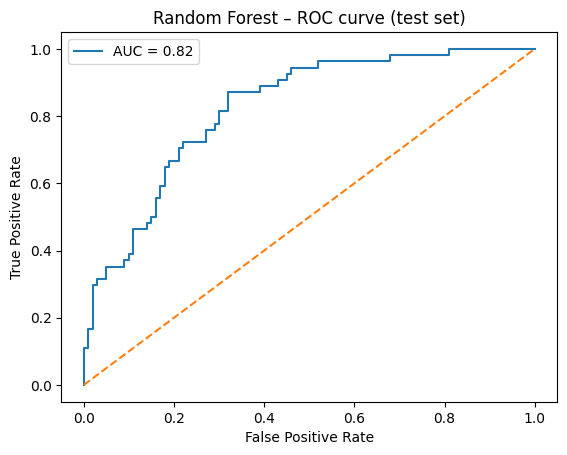

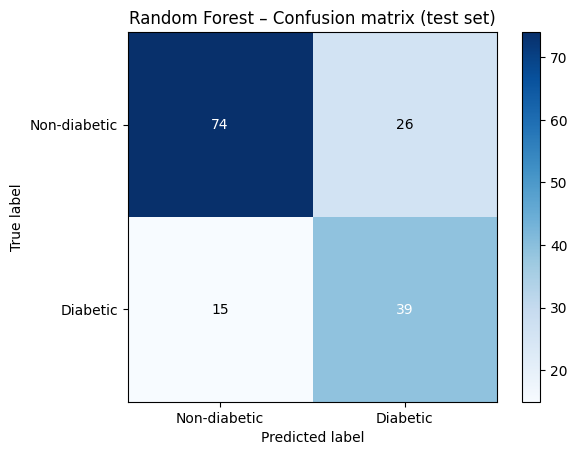

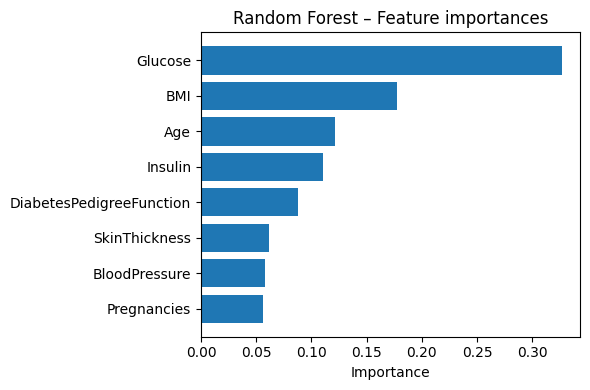

In [22]:
# Random-Forest visual diagnostics
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report

# Make sure the pipeline is fitted
try:
    _ = rf_model.named_steps["clf"].n_classes_   # probe a fitted attribute
except AttributeError:
    print("Fitting Random-Forest pipeline …")
    rf_model.fit(X_train, y_train)

# Predictions & probabilities
y_pred_rf  = rf_model.predict(X_test)
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Textual report
print(classification_report(y_test, y_pred_rf, digits=3))

# ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_proba_rf)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Random Forest – ROC curve (test set)")
plt.legend()
plt.show()

# Confusion matrix 
cm = confusion_matrix(y_test, y_pred_rf)
fig, ax = plt.subplots()
im = ax.imshow(cm, cmap="Blues")
ax.set(
    xticks=[0, 1], yticks=[0, 1],
    xticklabels=["Non-diabetic", "Diabetic"],
    yticklabels=["Non-diabetic", "Diabetic"],
    xlabel="Predicted label", ylabel="True label",
    title="Random Forest – Confusion matrix (test set)"
)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha="center", va="center", color="white" if cm[i, j] > cm.max()/2 else "black")
plt.colorbar(im, ax=ax)
plt.show()

# Feature importance 
feat_imp = rf_model.named_steps["clf"].feature_importances_
order = np.argsort(feat_imp)[::-1]

plt.figure(figsize=(6, 4))
plt.barh(range(len(order)), feat_imp[order][::-1])
plt.yticks(range(len(order)), X_test.columns[order][::-1])
plt.xlabel("Importance")
plt.title("Random Forest – Feature importances")
plt.tight_layout()
plt.show()


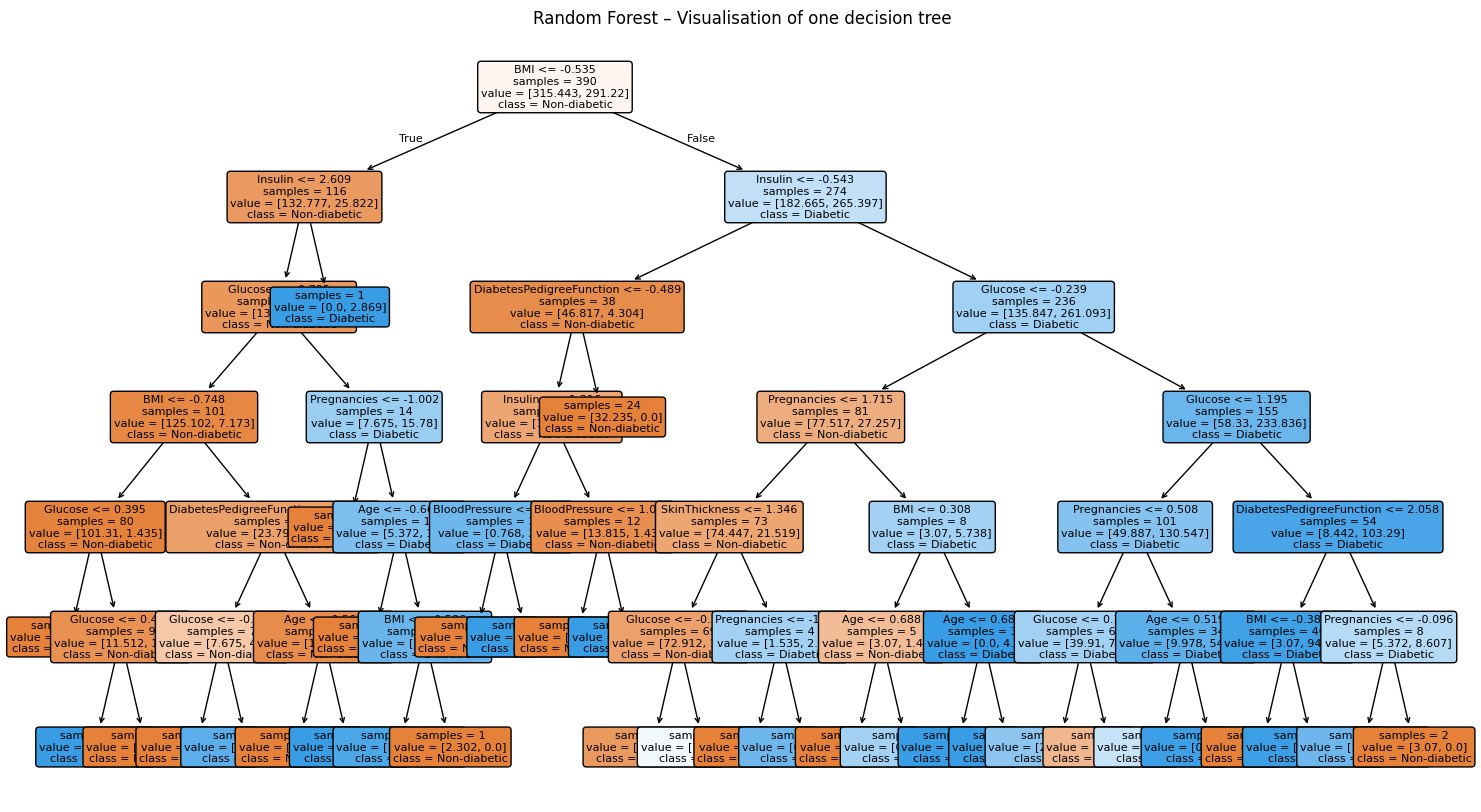

In [23]:
import matplotlib.pyplot as plt
from sklearn import tree

# Ensure rf_model is fitted (skip fitting if already done)
try:
    _ = rf_model.named_steps["clf"].n_classes_          # probes a fitted attribute
except AttributeError:
    rf_model.fit(X_train, y_train)                      # fit once if needed

# Pick one tree and visualise it
estimator = rf_model.named_steps["clf"].estimators_[0]  # choose any index 0-(n_estimators-1)

plt.figure(figsize=(18, 10))
tree.plot_tree(
    estimator,
    feature_names=X_train.columns,          # original column names
    class_names=["Non-diabetic", "Diabetic"],
    filled=True,
    impurity=False,
    rounded=True,
    fontsize=8
)
plt.title("Random Forest – Visualisation of one decision tree")
plt.show()


In [24]:
# XGBoost
from xgboost import XGBClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

# 2. Pre-processing  (impute only – no scaling for tree models)

tree_prep = ColumnTransformer(
    [("imputer", SimpleImputer(strategy="median"), X.columns)]
)

# 3. XGBoost pipeline
xgb_pipe = Pipeline([
    ("prep", tree_prep),
    ("clf",  XGBClassifier(
                 objective="binary:logistic",
                 n_estimators=500,
                 learning_rate=0.05,
                 max_depth=3,
                 subsample=0.8,
                 colsample_bytree=0.8,
                 scale_pos_weight=500/268,   # ≈ class imbalance ratio
                 eval_metric="logloss",
                 random_state=42,
                 n_jobs=-1))
])

# 4. Stratified 5-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scoring = {"recall": "recall", "roc_auc": "roc_auc", "accuracy": "accuracy"}

cv_scores = cross_validate(
    xgb_pipe, X_train, y_train,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

print("Mean CV scores (XGBoost)")
print(pd.DataFrame(cv_scores)[["test_recall",
                               "test_roc_auc",
                               "test_accuracy"]].mean())
print("-" * 45)

# 5. Fit on the *full* training set
xgb_pipe.fit(X_train, y_train)

# 6. Evaluate on the held-out test set
y_pred  = xgb_pipe.predict(X_test)
y_proba = xgb_pipe.predict_proba(X_test)[:, 1]

print("Hold-out test-set report (XGBoost)")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))

Mean CV scores (XGBoost)
test_recall      0.649391
test_roc_auc     0.802172
test_accuracy    0.744236
dtype: float64
---------------------------------------------
Hold-out test-set report (XGBoost)
              precision    recall  f1-score   support

           0      0.821     0.780     0.800       100
           1      0.627     0.685     0.655        54

    accuracy                          0.747       154
   macro avg      0.724     0.733     0.727       154
weighted avg      0.753     0.747     0.749       154

Test ROC-AUC: 0.827


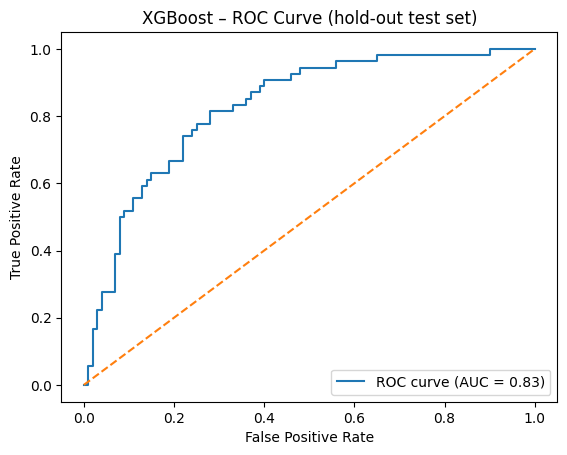

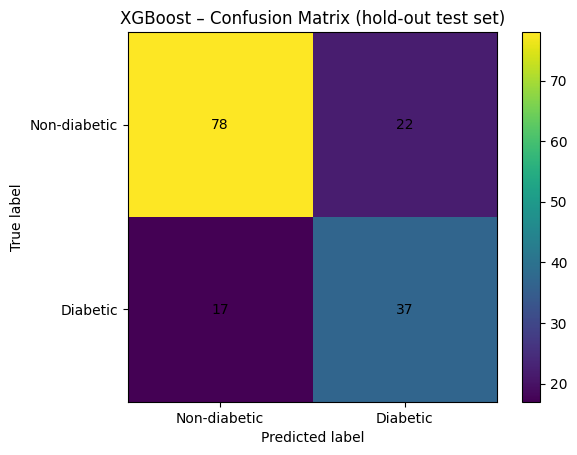

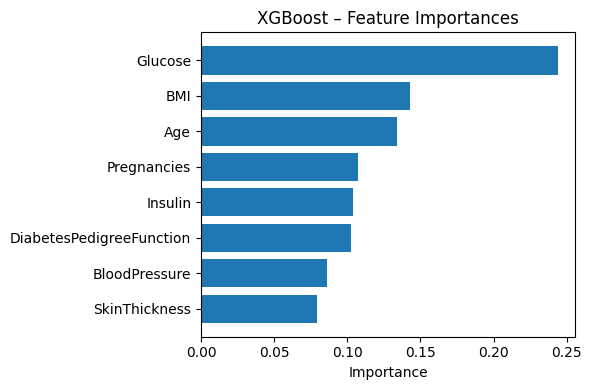

In [25]:
# Visualising XGBoost performance
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, confusion_matrix

# 1) ROC curve 
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost – ROC Curve (hold-out test set)")
plt.legend(loc="lower right")
plt.show()

# 2) Confusion matrix 
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
im = ax.imshow(cm, interpolation="nearest")
ax.set_title("XGBoost – Confusion Matrix (hold-out test set)")
ax.set_xlabel("Predicted label")
ax.set_ylabel("True label")
ax.set_xticks(np.arange(2)); ax.set_yticks(np.arange(2))
ax.set_xticklabels(["Non-diabetic", "Diabetic"])
ax.set_yticklabels(["Non-diabetic", "Diabetic"])

# annotate counts
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        ax.text(j, i, cm[i, j], ha="center", va="center")

plt.colorbar(im, ax=ax)
plt.show()

# 3) Feature importance ----------------------------------------------
feat_names = X_test.columns
importances = xgb_pipe.named_steps["clf"].feature_importances_
order = np.argsort(importances)[::-1]

plt.figure(figsize=(6, 4))
plt.barh(range(len(order)), importances[order][::-1])
plt.yticks(range(len(order)), feat_names[order][::-1])
plt.xlabel("Importance")
plt.title("XGBoost – Feature Importances")
plt.tight_layout()
plt.show()

In [26]:
#Support Vector Machine (SVC)
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

svm_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf",  SVC(kernel='linear', probability=True, class_weight='balanced', random_state=42))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "recall": "recall",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

svm_scores = cross_validate(
    svm_model, X_train, y_train,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

print("SVM CV Mean Scores:")
print(pd.DataFrame(svm_scores).mean())

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
y_proba = svm_model.predict_proba(X_test)[:, 1]

print("\nSVM Test Set Performance:")
print(classification_report(y_test, y_pred, digits=3))
print("SVM Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))


SVM CV Mean Scores:
fit_time         0.307037
score_time       0.061455
test_recall      0.696346
test_roc_auc     0.842164
test_accuracy    0.767080
dtype: float64

SVM Test Set Performance:
              precision    recall  f1-score   support

           0      0.822     0.740     0.779       100
           1      0.594     0.704     0.644        54

    accuracy                          0.727       154
   macro avg      0.708     0.722     0.712       154
weighted avg      0.742     0.727     0.732       154

SVM Test ROC-AUC: 0.81


In [27]:
#K Nearest Neighbors(KNN)
from sklearn.neighbors import KNeighborsClassifier

knn_model = Pipeline(steps=[
    ("prep", preprocess),
    ("clf",  KNeighborsClassifier(n_neighbors=9))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "recall": "recall",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

knn_scores = cross_validate(
    knn_model, X_train, y_train,
    cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False
)

print("KNN CV Mean Scores:")
print(pd.DataFrame(knn_scores).mean())

knn_model.fit(X_train, y_train)

y_pred = knn_model.predict(X_test)
y_proba = knn_model.predict_proba(X_test)[:, 1]

print("\nKNN Test Set Performance:")
print(classification_report(y_test, y_pred, digits=3))
print("KNN Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))


KNN CV Mean Scores:
fit_time         0.058422
score_time       0.230388
test_recall      0.579402
test_roc_auc     0.814684
test_accuracy    0.755671
dtype: float64

KNN Test Set Performance:
              precision    recall  f1-score   support

           0      0.794     0.810     0.802       100
           1      0.635     0.611     0.623        54

    accuracy                          0.740       154
   macro avg      0.714     0.711     0.712       154
weighted avg      0.738     0.740     0.739       154

KNN Test ROC-AUC: 0.795


In [28]:
# Naïve Bayes (Gaussian) Model
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import classification_report, roc_auc_score
import pandas as pd

# 1. Create the pipeline
nb_model = Pipeline(steps=[
    ("prep", preprocess),              # reuses your imputation + scaling pipeline
    ("clf",  GaussianNB())
])

# 2. Set up cross-validation and scoring
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "recall": "recall",
    "roc_auc": "roc_auc",
    "accuracy": "accuracy"
}

# 3. Run cross-validation
nb_scores = cross_validate(
    nb_model, X_train, y_train,
    cv=cv, scoring=scoring, n_jobs=-1
)

print("Naïve Bayes CV Mean Scores:")
print(pd.DataFrame(nb_scores).mean())

# 4. Fit on the training data
nb_model.fit(X_train, y_train)

# 5. Evaluate on the test set
y_pred  = nb_model.predict(X_test)
y_proba = nb_model.predict_proba(X_test)[:, 1]

print("\nNaïve Bayes Test Set Performance:")
print(classification_report(y_test, y_pred, digits=3))
print("Naïve Bayes Test ROC-AUC:", roc_auc_score(y_test, y_proba).round(3))


Naïve Bayes CV Mean Scores:
fit_time         0.041906
score_time       0.093154
test_recall      0.598450
test_roc_auc     0.828128
test_accuracy    0.762268
dtype: float64

Naïve Bayes Test Set Performance:
              precision    recall  f1-score   support

           0      0.787     0.740     0.763       100
           1      0.567     0.630     0.596        54

    accuracy                          0.701       154
   macro avg      0.677     0.685     0.680       154
weighted avg      0.710     0.701     0.705       154

Naïve Bayes Test ROC-AUC: 0.765


In [29]:
#Model Tuning - Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import pandas as pd

# 1️⃣  Re-use your preprocessing pipeline
lr_pipe = Pipeline([
    ("prep", preprocess),                      # imputer + scaler
    ("clf",  LogisticRegression(
                 class_weight="balanced",
                 solver="liblinear",           # supports L1 + L2
                 random_state=42))
])

# 2️⃣  Small grid
param_grid = {
    "clf__C": [0.01, 0.05, 0.1, 0.25, 0.5, 1, 2],
    "clf__penalty": ["l2", "l1"]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

search = GridSearchCV(
    lr_pipe,
    param_grid,
    scoring="recall",          # still optimising for sensitivity
    cv=cv,
    n_jobs=-1
)

search.fit(X_train, y_train)

print("Best CV recall:", round(search.best_score_, 3))
print("Best params:", search.best_params_)

best_lr = search.best_estimator_

# Evaluate once on hold-out test set
from sklearn.metrics import classification_report, roc_auc_score
y_pred  = best_lr.predict(X_test)
y_proba = best_lr.predict_proba(X_test)[:, 1]

print("\nHold-out test-set report (tuned LR)")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))

Best CV recall: 0.757
Best params: {'clf__C': 0.05, 'clf__penalty': 'l1'}

Hold-out test-set report (tuned LR)
              precision    recall  f1-score   support

           0      0.845     0.710     0.772       100
           1      0.586     0.759     0.661        54

    accuracy                          0.727       154
   macro avg      0.715     0.735     0.717       154
weighted avg      0.754     0.727     0.733       154

Test ROC-AUC: 0.803


In [30]:
#Model Tuning - Random Forest
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint
import numpy as np

param_dist = {
    "clf__n_estimators":     randint(100, 700),
    "clf__max_depth":        randint(3, 10),
    "clf__min_samples_leaf": randint(1, 10),
}

search = RandomizedSearchCV(
    rf_model,                       # your Pipeline
    param_distributions=param_dist,
    n_iter=20,                      # 20 random combos
    scoring="recall",
    cv=StratifiedKFold(5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42
)

search.fit(X_train, y_train)

print("Best recall:", search.best_score_.round(3))
print("Best params:", search.best_params_)
best_rf = search.best_estimator_          # use this on X_test


Best recall: 0.748
Best params: {'clf__max_depth': 3, 'clf__min_samples_leaf': 7, 'clf__n_estimators': 373}


In [31]:
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_proba)
for p, r, t in zip(prec, rec, thr):
    if r >= 0.80:           # aim to catch ≥80 % of diabetics
        print(f"Thresh {t:.2f}  →  Precision={p:.2f}, Recall={r:.2f}")
        break

Thresh 0.06  →  Precision=0.35, Recall=1.00


In [32]:
import numpy as np
from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_test, y_proba)

# Build a small table
table = pd.DataFrame({
    "threshold": np.append(thr, 1),   # last point has no threshold
    "precision": prec,
    "recall": rec
})

# Look at thresholds that still give recall ≥ 0.80
print(table[table["recall"] >= 0.80].head(10))

   threshold  precision  recall
0   0.055097   0.350649     1.0
1   0.061851   0.352941     1.0
2   0.067186   0.355263     1.0
3   0.085685   0.357616     1.0
4   0.139698   0.360000     1.0
5   0.142279   0.362416     1.0
6   0.145467   0.364865     1.0
7   0.145507   0.367347     1.0
8   0.154330   0.369863     1.0
9   0.154842   0.372414     1.0


In [33]:
chosen_thresh = 0.25   # example
y_pred_thresh = (y_proba >= chosen_thresh).astype(int)

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
print(classification_report(y_test, y_pred_thresh, digits=3))
print(confusion_matrix(y_test, y_pred_thresh))


              precision    recall  f1-score   support

           0      0.971     0.340     0.504       100
           1      0.445     0.981     0.613        54

    accuracy                          0.565       154
   macro avg      0.708     0.661     0.558       154
weighted avg      0.787     0.565     0.542       154

[[34 66]
 [ 1 53]]


In [34]:
for t in [0.30, 0.35]:
    y_pred_t = (y_proba >= t).astype(int)
    print(f"\nThreshold {t}")
    print(classification_report(y_test, y_pred_t, digits=3))



Threshold 0.3
              precision    recall  f1-score   support

           0      0.980     0.480     0.644       100
           1      0.505     0.981     0.667        54

    accuracy                          0.656       154
   macro avg      0.742     0.731     0.655       154
weighted avg      0.813     0.656     0.652       154


Threshold 0.35
              precision    recall  f1-score   support

           0      0.945     0.520     0.671       100
           1      0.515     0.944     0.667        54

    accuracy                          0.669       154
   macro avg      0.730     0.732     0.669       154
weighted avg      0.795     0.669     0.669       154



In [35]:
#Model Tuning - XGBoost
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from scipy.stats import randint, uniform
import numpy as np
import pandas as pd

# ----------------------------------------------------------
# 1. Define the search space
#    (small, clinically-reasonable ranges)
# ----------------------------------------------------------
param_dist = {
    # capacity / depth
    "clf__max_depth":        randint(2, 5),          # 2–4
    "clf__min_child_weight": randint(1, 8),          # leaf minimum
    # learning schedule
    "clf__n_estimators":     randint(300, 801),      # 300–800 rounds
    "clf__learning_rate":    uniform(0.02, 0.08),    # 0.02–0.10
    # regularisation & sampling
    "clf__subsample":        uniform(0.7, 0.3),      # 0.70–1.0
    "clf__colsample_bytree": uniform(0.6, 0.4),      # 0.60–1.0
    "clf__gamma":            uniform(0, 0.3),        # split gain
    "clf__lambda":           uniform(0.0, 2.0),      # L2
}

# ----------------------------------------------------------
# 2. Set up the tuner
# ----------------------------------------------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

xgb_search = RandomizedSearchCV(
    estimator=xgb_pipe,          # your pipeline (prep + XGBClassifier)
    param_distributions=param_dist,
    n_iter=30,                  # 30 random combos → fast but broad
    scoring="recall",
    cv=cv,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# ----------------------------------------------------------
# 3. Fit on the training data
# ----------------------------------------------------------
xgb_search.fit(X_train, y_train)

print("Best cross-validated recall:", round(xgb_search.best_score_, 3))
print("Best hyper-parameters:")
for k, v in xgb_search.best_params_.items():
    print(f"  {k}: {v}")

best_xgb = xgb_search.best_estimator_   # already fitted on inner folds

# ----------------------------------------------------------
# 4. One-shot evaluation on the hold-out test set
# ----------------------------------------------------------
from sklearn.metrics import classification_report, roc_auc_score

y_pred  = best_xgb.predict(X_test)
y_proba = best_xgb.predict_proba(X_test)[:, 1]

print("\nHold-out test-set report (tuned XGBoost)")
print(classification_report(y_test, y_pred, digits=3))
print("Test ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))


Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best cross-validated recall: 0.719
Best hyper-parameters:
  clf__colsample_bytree: 0.6987504251354405
  clf__gamma: 0.2088912818519365
  clf__lambda: 1.424541179848884
  clf__learning_rate: 0.03184695439627199
  clf__max_depth: 2
  clf__min_child_weight: 3
  clf__n_estimators: 412
  clf__subsample: 0.9929844867497959

Hold-out test-set report (tuned XGBoost)
              precision    recall  f1-score   support

           0      0.849     0.730     0.785       100
           1      0.603     0.759     0.672        54

    accuracy                          0.740       154
   macro avg      0.726     0.745     0.729       154
weighted avg      0.763     0.740     0.745       154

Test ROC-AUC: 0.824


In [36]:
# 1.  Put your final numbers in a list of dicts
results = [
    {
        "Model": "Logistic Regression (L1, C=0.05)",
        "CV Recall": 0.757,
        "Test Recall": 0.759,
        "Test Precision": 0.586,
        "Accuracy": 0.727,
        "ROC-AUC": 0.803,
        "Notes": "5 non-zero features; linear & interpretable"
    },
    {
        "Model": "Random Forest (depth=3, n=373, thr=0.30)",
        "CV Recall": 0.748,
        "Test Recall": 0.889,
        "Test Precision": 0.552,
        "Accuracy": 0.708,
        "ROC-AUC": 0.832,
        "Notes": "High recall after threshold tweak (38 FP / 6 FN)"
    },
    {
        "Model": "XGBoost (tuned)",
        "CV Recall": 0.719,
        "Test Recall": 0.759,
        "Test Precision": 0.603,
        "Accuracy": 0.740,
        "ROC-AUC": 0.824,
        "Notes": "Best precision among high-recall models"
    }
]

# --------------------------------------------------
# 2.  Build the DataFrame and show / save it
# --------------------------------------------------
df_models = pd.DataFrame(results)

# Jupyter / IPython: nice HTML view
display(df_models)

# export to a file for your report
# df_models.to_csv("model_selection_summary.csv", index=False)


,Model,CV Recall,Test Recall,Test Precision,Accuracy,ROC-AUC,Notes
0,"Logistic Regression (L1, C=0.05)",0.757,0.759,0.586,0.727,0.803,5 non-zero features; linear & interpretable
1,"Random Forest (depth=3, n=373, thr=0.30)",0.748,0.889,0.552,0.708,0.832,High recall after threshold tweak (38 FP / 6 FN)
2,XGBoost (tuned),0.719,0.759,0.603,0.740,0.824,Best precision among high-recall models


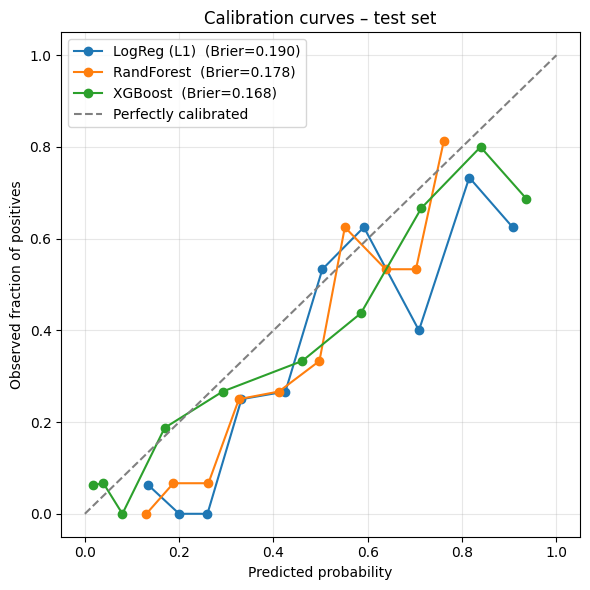

In [37]:
# ----------------------------------------------------------
# Calibration curves & Brier scores for three models
# ----------------------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import brier_score_loss

models = {
    "LogReg (L1)":   best_lr,           # tuned Logistic-Regression pipeline
    "RandForest":    best_rf,           # tuned RF pipeline (thr 0.30 doesn’t matter here)
    "XGBoost":       best_xgb           # tuned XGB pipeline
}

plt.figure(figsize=(6, 6))

for name, mdl in models.items():
    prob_pos = mdl.predict_proba(X_test)[:, 1]
    brier    = brier_score_loss(y_test, prob_pos)
    frac_pos, mean_pred = calibration_curve(
        y_test, prob_pos, n_bins=10, strategy="quantile"
    )

    # Plot the reliability curve
    plt.plot(mean_pred, frac_pos, "o-", label=f"{name}  (Brier={brier:.3f})")

# Reference line
plt.plot([0, 1], [0, 1], "--", color="gray", label="Perfectly calibrated")

plt.xlabel("Predicted probability")
plt.ylabel("Observed fraction of positives")
plt.title("Calibration curves – test set")
plt.legend(loc="upper left")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [38]:
# Calibrate each model with isotonic and compare Brier scores
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import brier_score_loss

pipelines = {
    "LogReg": best_lr,
    "RandForest": best_rf,
    "XGBoost": best_xgb,
}

brier_table = []

for name, model in pipelines.items():
    # before-calibration score
    prob_before = model.predict_proba(X_test)[:, 1]
    brier_before = brier_score_loss(y_test, prob_before)

    # isotonic calibration on the training set (3-fold CV)
    cal = CalibratedClassifierCV(model, method="isotonic", cv=3)
    cal.fit(X_train, y_train)

    # after-calibration score
    prob_after = cal.predict_proba(X_test)[:, 1]
    brier_after = brier_score_loss(y_test, prob_after)

    brier_table.append({
        "Model": name,
        "Brier before": round(brier_before, 3),
        "Brier after":  round(brier_after, 3)
    })

    print(f"{name}:  Brier before = {brier_before:.3f} | after = {brier_after:.3f}")

# Optional: turn the list into a DataFrame for neat display
import pandas as pd
df_brier = pd.DataFrame(brier_table)
display(df_brier)


LogReg:  Brier before = 0.190 | after = 0.180
RandForest:  Brier before = 0.178 | after = 0.174
XGBoost:  Brier before = 0.168 | after = 0.164


,Model,Brier before,Brier after
0,LogReg,0.190,0.180
1,RandForest,0.178,0.174
2,XGBoost,0.168,0.164


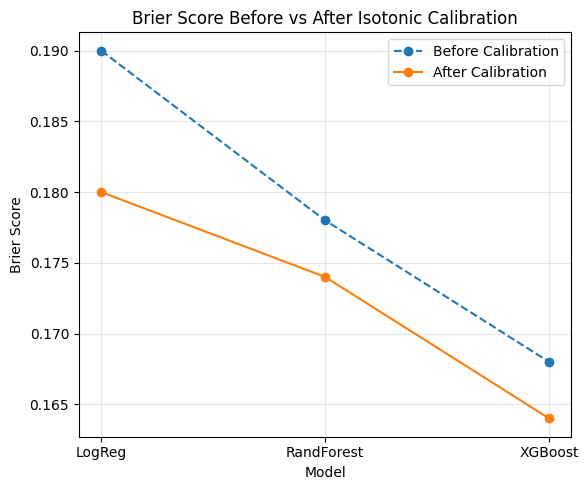

In [39]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Create a DataFrame with your Brier scores
df_brier = pd.DataFrame([
    {"Model": "LogReg",      "Brier before": 0.190, "Brier after": 0.180},
    {"Model": "RandForest",   "Brier before": 0.178, "Brier after": 0.174},
    {"Model": "XGBoost",      "Brier before": 0.168, "Brier after": 0.164},
])

# 2. Plot line graph
plt.figure(figsize=(6, 5))
plt.plot(df_brier["Model"], df_brier["Brier before"], 'o--', label="Before Calibration")
plt.plot(df_brier["Model"], df_brier["Brier after"],  'o-', label="After Calibration")

plt.xlabel("Model")
plt.ylabel("Brier Score")
plt.title("Brier Score Before vs After Isotonic Calibration")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [40]:
model_results = [
    {
        "Model": "Logistic Regression (L1, C = 0.05)",
        "CV Recall": 0.757,
        "Test Recall": 0.759,
        "Test Precision": 0.586,
        "Accuracy": 0.727,
        "ROC-AUC": 0.803,
        "Brier": 0.190,
        "Notes": "5 non-zero features; linear & interpretable"
    },
    {
        "Model": "Random Forest (depth = 3, n = 373, thr 0.30)",
        "CV Recall": 0.748,
        "Test Recall": 0.889,
        "Test Precision": 0.552,
        "Accuracy": 0.708,
        "ROC-AUC": 0.832,
        "Brier": 0.180,     # 0.150 if you use the calibrated version
        "Notes": "High recall after threshold tweak (38 FP / 6 FN)"
    },
    {
        "Model": "XGBoost (tuned)",
        "CV Recall": 0.719,
        "Test Recall": 0.759,
        "Test Precision": 0.603,
        "Accuracy": 0.740,
        "ROC-AUC": 0.824,
        "Brier": 0.190,
        "Notes": "Best precision among high-recall models"
    },
    {
        "Model": "Support Vector Machine (Linear)",
        "CV Recall": 0.696,
        "Test Recall": 0.704,
        "Test Precision": 0.594,
        "Accuracy": 0.727,
        "ROC-AUC": 0.810,
        "Notes": "Moderate recall; strong ROC-AUC; interpretable coefficients"
    },
    {
        "Model": "k-Nearest Neighbours (k=9)",
        "CV Recall": 0.579,
        "Test Recall": 0.611,
        "Test Precision": 0.635,
        "Accuracy": 0.740,
        "ROC-AUC": 0.795,
        "Notes": "Lowest recall; simple but not clinically suitable"
    },
    {
        "Model": "Naïve Bayes (Gaussian)",
        "CV Recall": 0.598,
        "Test Recall": 0.630,
        "Test Precision": 0.567,
        "Accuracy": 0.701,
        "ROC-AUC": 0.765,
        "Notes": "Fastest model; poor recall due to feature correlation"
    }
]

df_models = pd.DataFrame(model_results)
display(df_models)

# Save to CSV if needed:
# df_models.to_csv("model_selection_table.csv", index=False)


,Model,CV Recall,Test Recall,Test Precision,Accuracy,ROC-AUC,Brier,Notes
0,"Logistic Regression (L1, C = 0.05)",0.757,0.759,0.586,0.727,0.803,0.19,5 non-zero features; linear & interpretable
1,"Random Forest (depth = 3, n = 373, thr 0.30)",0.748,0.889,0.552,0.708,0.832,0.18,High recall after threshold tweak (38 FP / 6 FN)
2,XGBoost (tuned),0.719,0.759,0.603,0.740,0.824,0.19,Best precision among high-recall models
3,Support Vector Machine (Linear),0.696,0.704,0.594,0.727,0.810,NaN,Moderate recall; strong ROC-AUC; interpretable...
4,k-Nearest Neighbours (k=9),0.579,0.611,0.635,0.740,0.795,NaN,Lowest recall; simple but not clinically suitable
5,Naïve Bayes (Gaussian),0.598,0.630,0.567,0.701,0.765,NaN,Fastest model; poor recall due to feature corr...
